# Gesture Recognition

#### Import Libraries

In [1]:
import numpy as np
import os
import uuid
import random
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
# train and validatiaon data creator with ablation
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'/train.csv').readlines())
    val_doc = np.random.permutation(open(path+'/val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
base_path = 'datasets/Project_data'
train_doc, val_doc = get_data(base_path, ablation=None)
batch_size = 64  # Adjust batch size based on GPU capacity
enable_augmentation = False # augmentation of Data
dim_x, dim_y = 120, 120 
seq_idx = range(7,26,2)

## Generator

In [5]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train = False, augmentation = False, debug=False):
    img_idx = seq_idx
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmentation:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmentation and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = resize(image,(y,z))

                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels
                

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = base_path + '/train'
val_path = base_path + '/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 20 #Choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

#### Experiment 4

In [8]:
# # Defining Model
# model = Sequential()
# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

#### Experiment 5

In [9]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(5, activation='softmax'))

#### Experiment 6

In [10]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dense(5, activation='softmax'))

#### Experiment 7

In [11]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

#### Experiment 8

In [12]:
# model = Sequential()

# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
# model.add(MaxPooling3D(pool_size=(1, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

#### Experiment 9
**TimeDistributed Conv2D + GRU**

In [13]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())

# model.add(GRU(128))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

#### Experiment 10
**TimeDistributed Conv2D + Dense**

In [14]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(64, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(TimeDistributed(
#     Conv2D(128, (3,3), activation='relu'))
# )
# model.add(TimeDistributed(
#     MaxPooling2D((2,2)))
# )
# model.add(BatchNormalization())

# model.add(GlobalAveragePooling3D())
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(5, activation='softmax'))

#### Experiment 11
**TimeDistributed + ConvLSTM2D**

In [15]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Conv2D(16, (3,3), activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(
#     ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Dense(64, activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(5, activation='softmax'))

#### Experiment 12
**TimeDistributed + ConvLSTM2D**

In [16]:
# model = Sequential()
# model.add(TimeDistributed(
#     Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Conv2D(16, (3,3), activation='relu'))
# )
# model.add(BatchNormalization())
# model.add(
#     ConvLSTM2D(8, kernel_size=3, return_sequences=False)
# )
# model.add(BatchNormalization())
# model.add(TimeDistributed(
#     Dense(64, activation='relu'))
# )
# model.add(Dropout(0.5))  # Added dropout for regularization
# model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))  # Added dropout for regularization
# model.add(Dense(5, activation='softmax'))

#### Experiment 13
**TimeDistributed + ConvLSTM2D**

In [17]:
# model = Sequential()

# # First Conv Block
# model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same'), input_shape=input_shape))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling3D((1, 2, 2))))  # Pooling to reduce spatial dimensions

# # Second Conv Block
# model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling3D((1, 2, 2))))

# # ConvLSTM Layer for Temporal Learning
# model.add(ConvLSTM2D(32, (3,3), return_sequences=True, padding='same'))
# model.add(BatchNormalization())

# # Final ConvLSTM Block (Deeper for better learning)
# model.add(ConvLSTM2D(64, (3,3), return_sequences=False, padding='same'))
# model.add(BatchNormalization())

# # Global Pooling & Dense Layers
# model.add(GlobalAveragePooling2D())  
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))  # Regularization
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(5, activation='softmax'))  # Assuming 5 classes

# # Compile Model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#### Experiment 14
**TimeDistributed + ConvLSTM2D**

In [18]:
# model = Sequential()

# # First Conv Block (Reduced Filters)
# model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same'), input_shape=input_shape))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# # Second Conv Block (Minimal Filters)
# model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same')))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(MaxPooling2D((2, 2))))

# # Lightweight ConvLSTM Layer for Temporal Learning
# model.add(ConvLSTM2D(16, (3,3), return_sequences=False, padding='same'))  # Only 1 ConvLSTM to save params
# model.add(BatchNormalization())

# # Global Pooling & Dense Layers (Reduced Units)
# model.add(GlobalAveragePooling2D())  
# model.add(Dense(32, activation='relu'))  # Smaller dense layer
# model.add(Dropout(0.4))  # Slightly reduced dropout
# model.add(Dense(5, activation='softmax'))  # Assuming 5 classes

#### Experiment 15
**Conv3D**

In [19]:
model = Sequential()

# First Conv Block (Reduced Filters)
model.add(Conv3D(16, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Conv Block
model.add(Conv3D(32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))  

# ConvLSTM for Temporal Learning
model.add(ConvLSTM2D(32, kernel_size=(3,3), activation='relu', return_sequences=False, padding='same'))
model.add(BatchNormalization())

# Global Pooling & Dense Layers (Optimized)
model.add(GlobalAveragePooling2D())  
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))  
model.add(Dense(5, activation='softmax'))  # Output layer for 5 classes

2025-01-29 16:46:44.125996: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-29 16:46:44.126086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


#### Compile The Model

In [20]:
optimiser = Adam(learning_rate=0.01)  # Using Adam optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 10, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 60, 60, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 60, 60, 32)     13856     
                                                                 
 batch_normalization_1 (Batc  (None, 5, 60, 60, 32)    128       
 hNormalization)                                                 
                                                        

#### We will define the 
train_generator and the val_generator

In [21]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmentation = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

##### Moving the created models to a folder with a random Id for better organization

In [22]:
random_id = str(uuid.uuid4().hex[:6])

model_name = 'Models' + '/' + random_id + '/' + 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
os.makedirs(model_name, exist_ok=True)

        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.001, verbose=1)  # Reduce LR on plateau
# Define early stopping
ES = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, LR, ES]

The `steps_per_epoch` and `validation_steps` are used by `.fit` to decide the number of next() calls it need to make.

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### Model Fit

In [24]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


2025-01-29 16:46:52.071085: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


11/11 [==============================] - ETA: 0s - loss: 1.2948 - categorical_accuracy: 0.3849
Epoch 00001: val_loss improved from inf to 25.21007, saving model to Models/a25e86/model_init_2025-01-2916_46_43.165683/model-00001-1.29475-0.38494-25.21007-0.17969.h5
11/11 [==============================] - 56s 5s/step - loss: 1.2948 - categorical_accuracy: 0.3849 - val_loss: 25.2101 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.1559 - categorical_accuracy: 0.4162
Epoch 00002: val_loss did not improve from 25.21007
11/11 [==============================] - 50s 5s/step - loss: 1.1559 - categorical_accuracy: 0.4162 - val_loss: 46.0531 - val_categorical_accuracy: 0.1953 - lr: 0.0100
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.3438 - categorical_accuracy: 0.3764
Epoch 00003: val_loss did not improve from 25.21007
11/11 [==============================] - 53s 5s/step - loss: 1.3438 - categorical_accur

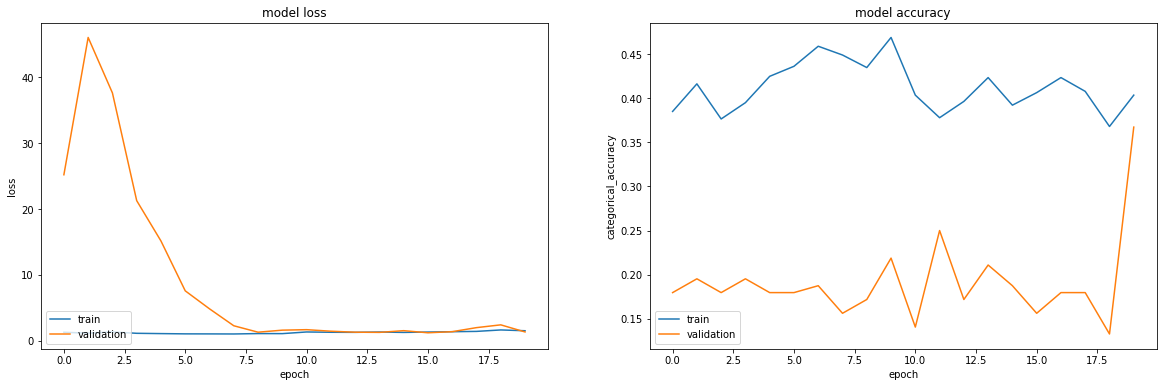

In [25]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')